In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
from xgcm import Grid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
from PIL import Image


In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39961,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://10.6.121.30:35887,Total threads: 1
Dashboard: /proxy/43325/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:42041,


In [3]:
db='/g/data/x77/amh157/PanAnt/panant.db'
session=cc.database.create_session(db)

In [4]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [5]:
ee = explore.ExperimentExplorer(session=session)
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [6]:
def change_lon_space(ds, grid):
    if grid == 'u':
        #ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        
        #for 0-360
        ds['_lon_adj'] = xr.where(ds['xq'] < 0, ds['xq'] + 360, ds['xq'])
        #do this line as well if want to switch to -180 to 180
        ds['_lon_adj'] = xr.where(ds['_lon_adj'] >180, ds['_lon_adj'] - 360, ds['_lon_adj'])

        ds = ds.swap_dims({'xq': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('xq')
        ds = ds.rename({'_lon_adj': 'xq'})
    elif grid == 't':
        #ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        
        #for 0-360
        ds['_lon_adj'] = xr.where(ds['xh'] < 0, ds['xh'] + 360, ds['xh'])
        #do this line as well if want to switch to -180 to 180
        ds['_lon_adj'] = xr.where(ds['_lon_adj'] >180, ds['_lon_adj'] - 360, ds['_lon_adj'])
        
        ds = ds.swap_dims({'xh': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('xh')
        ds = ds.rename({'_lon_adj': 'xh'})
    return ds

In [12]:
depth = cc.querying.getvar('panant-v2','deptho',session,n=1)
depth=change_lon_space(depth, 't')

land_mask = np.squeeze(depth.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [13]:
depth

<xarray.DataArray 'deptho' (yh: 1690, xh: 7200)>
dask.array<getitem, shape=(1690, 7200), dtype=float32, chunksize=(1690, 7200), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -81.1 -81.08 -81.06 -81.03 ... -37.16 -37.12 -37.08
  * xh       (xh) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Attributes:
    units:          m
    long_name:      Sea Floor Depth
    cell_methods:   area:mean yh:mean xh:mean time: point
    cell_measures:  area: areacello
    standard_name:  sea_floor_depth_below_geoid
    ncfiles:        ['/g/data4/x77/amh157/PanAnt/archive/panant-v2/output032/...

## Plot example of daily bottome temp¶

In [14]:
start = '1996-01-01 00:00:00'
end = '1999-01-01 00:00:00'

In [15]:
tob = cc.querying.getvar('panant-v2','tob', session).sel(time=slice(start,end)).sel(yh=slice(-70,-55)).sel(xh=slice(-265,-255))
tob=change_lon_space(tob, 't')

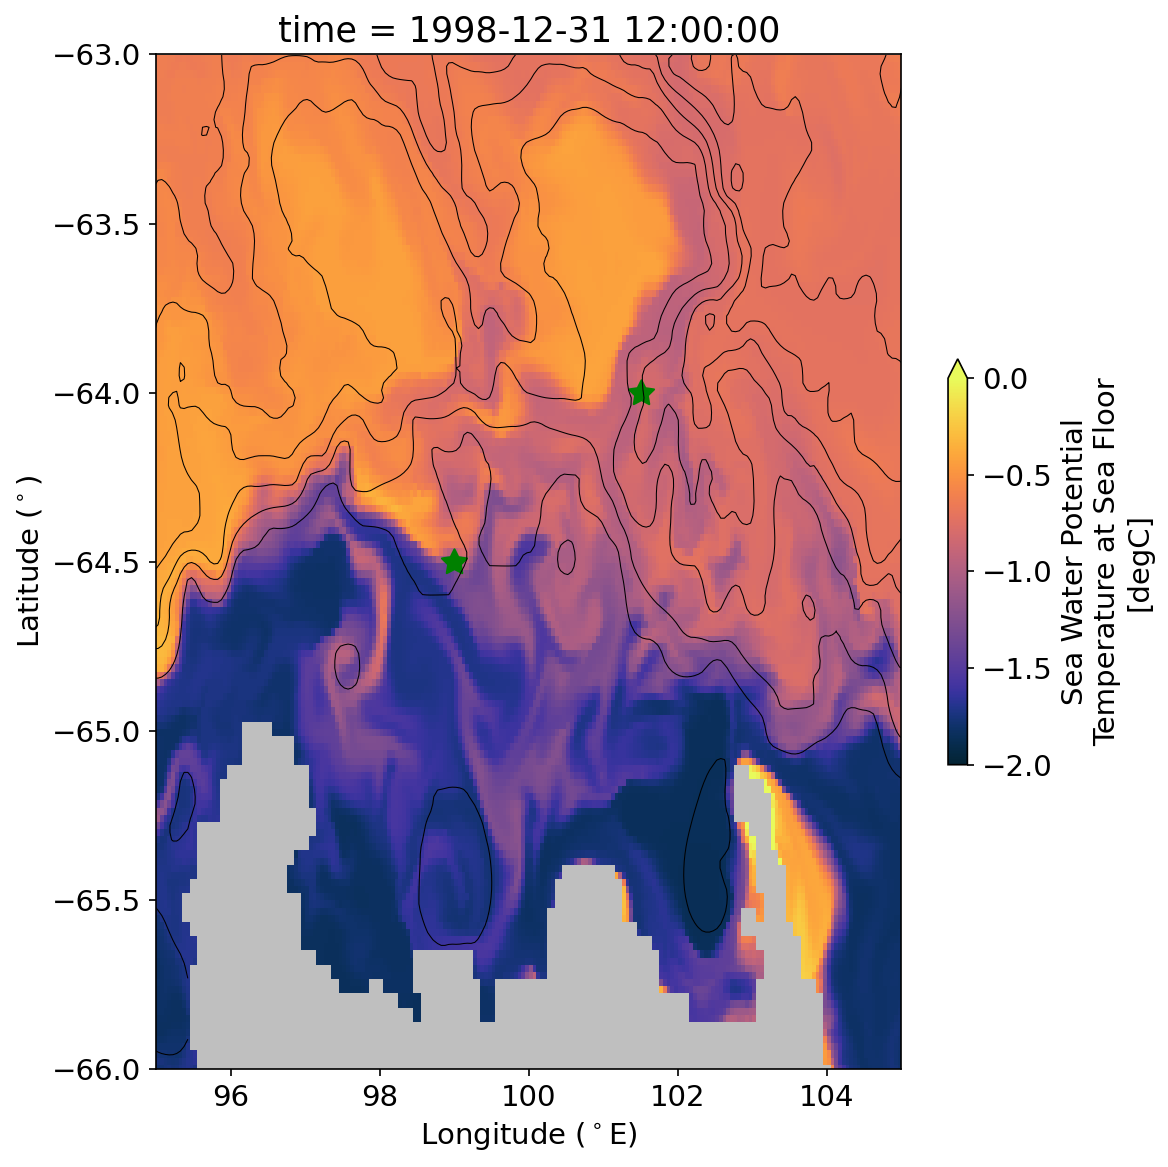

In [27]:
fontsize=12
clev2 = np.arange(0,6000,500)

fig = plt.figure(figsize=(8, 8), dpi=150)
plt.subplot(1, 1, 1)
plt.gca().patch.set_color('.75')

p2=tob.isel(time=-1).plot(vmin=-2,vmax=0.,cmap=cm.cm.thermal,cbar_kwargs={'shrink': 0.4})
plt.contour(depth.xh,depth.yh,depth,levels=clev2,colors='k',linewidths=0.5)

#plt.scatter(-260,-65.7,s=80, color='green',marker=(5, 1))

plt.scatter(-261+360,-64.5,s=160, color='green',marker=(5, 1))
plt.scatter(-258.5+360,-64,s=160, color='green',marker=(5, 1))

plt.xlabel('Longitude ($^\circ$E)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-66,-63])
#plt.xlim([-270,-250])

plt.tight_layout()

plt.savefig('panant_Denman_sflrT.png')


In [21]:
#Denman glacier coords from wikipedia
#Coordinates	66°45′S 99°30′E
#Width	16 km (10 mi)

denglac_tob=tob.sel(yh=-65.7,method='nearest').sel(xh=-260+360,method='nearest')
denEtrough_tob=tob.sel(yh=-64,method='nearest').sel(xh=-258.5+360,method='nearest') #plt.scatter(-258.5,-64,s=80, color='green',marker=(5, 1))
denWtrough_tob=tob.sel(yh=-64.5,method='nearest').sel(xh=-261+360,method='nearest') #plt.scatter(-261,-64.5,s=80, color='green',marker=(5, 1))

In [24]:
t=len(denglac_tob)
t=np.arange(0,len(denglac_tob),1)
t

array([   0,    1,    2, ..., 1092, 1093, 1094])

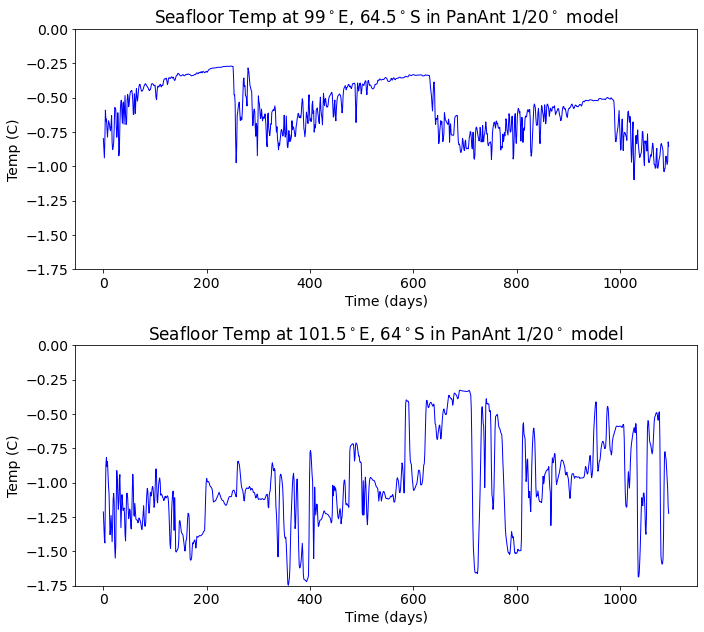

In [24]:
#denglac_tob.plot()
myr=36 #annual means start in 1958, seasonal in 59
t=np.arange(0,len(denglac_tob),1)
fig = plt.figure(figsize=(10, 9))

plt.rcParams['font.size'] = '14'

#ax1=plt.subplot(311)
#ax1.plot(t,denglac_tob,linestyle='-',color='b',linewidth=1)
##ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-2,1))
#ax1.set_xlabel('Time (days)',color='k')
#ax1.set_ylabel('Temp (C)',color='k')
##ax1.tick_params('y', colors='k')
#plt.title('Seafloor Temp at Denman Glacier (100$^\circ$E, 65.7$^\circ$S) in PanAnt 1/20$^\circ$ model')
##ax1.set_xlabel('Years')

ax1=plt.subplot(211)
ax1.plot(t,denEtrough_tob,linestyle='-',color='b',linewidth=1)
#ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-1.75,0))
ax1.set_xlabel('Time (days)',color='k')
ax1.set_ylabel('Temp (C)',color='k')
#ax1.tick_params('y', colors='k')
plt.title('Seafloor Temp at 99$^\circ$E, 64.5$^\circ$S in PanAnt 1/20$^\circ$ model')
#ax1.set_xlabel('Years')

ax1=plt.subplot(212)
ax1.plot(t,denWtrough_tob,linestyle='-',color='b',linewidth=1)
#ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-1.75,0))
ax1.set_xlabel('Time (days)',color='k')
ax1.set_ylabel('Temp (C)',color='k')
#ax1.tick_params('y', colors='k')
plt.title('Seafloor Temp at 101.5$^\circ$E, 64$^\circ$S in PanAnt 1/20$^\circ$ model')
#ax1.set_xlabel('Years')

plt.tight_layout()

plt.savefig('panant_Denman_sflrT_ts.png')


## Plot example of daily surface temp¶


In [13]:
start = '1997-01-01 00:00:00'
end = '1999-01-01 00:00:00'

In [14]:
tos = cc.querying.getvar('panant-v2','tos', session).sel(time=slice(start,end)).sel(yh=slice(-70,-55)).sel(xh=slice(-270,-250))
tos

<xarray.DataArray 'tos' (time: 730, yh: 1690, xh: 7200)>
dask.array<getitem, shape=(730, 1690, 7200), dtype=float32, chunksize=(31, 1690, 7200), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 -81.1 -81.08 -81.06 -81.03 ... -37.16 -37.12 -37.08
  * time     (time) object 1997-01-01 12:00:00 ... 1998-12-31 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Surface Temperature
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature
    time_bnds:      <xarray.DataArray 'time_bnds' (time: 2920, nv: 2)>\ndask....
    ncfiles:        ['/g/data4/x77/amh157/PanAnt/archive/panant-v2/output000/...

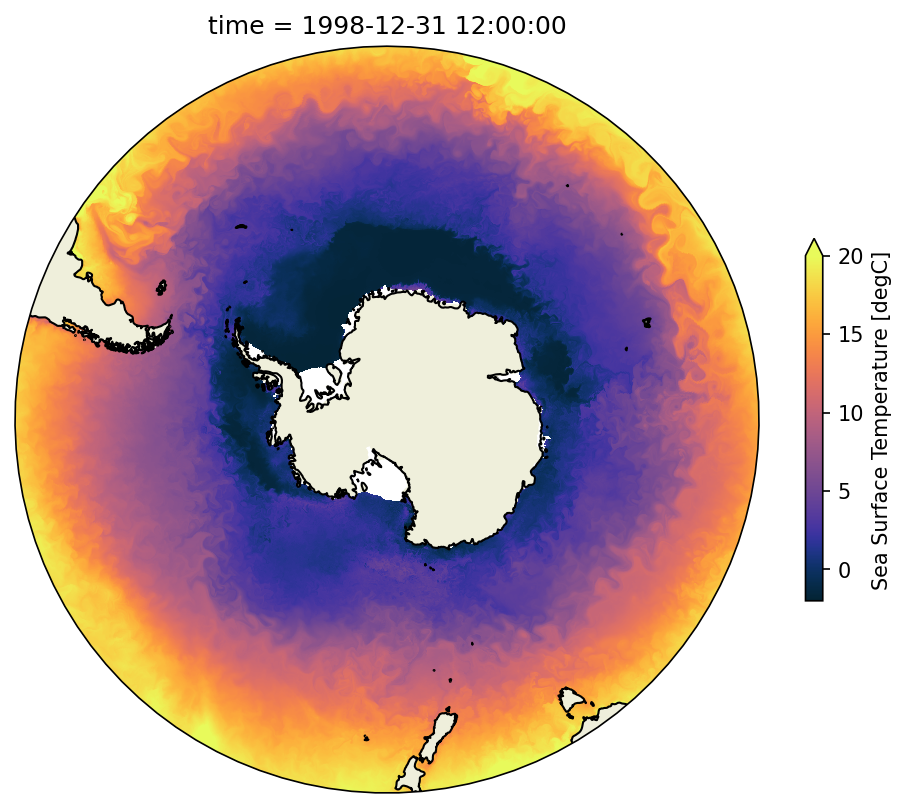

In [9]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(8, 8), dpi=150)
ax = plt.subplot(1, 1, 1, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 80, -82, -37], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

tob.isel(time=-1).plot(vmin=-2,vmax=20,transform=ccrs.PlateCarree(),cmap=cm.cm.thermal,cbar_kwargs={'shrink': 0.4})
#plt.savefig('figures/tos_snapshot.png')

(-270.0, -250.0)

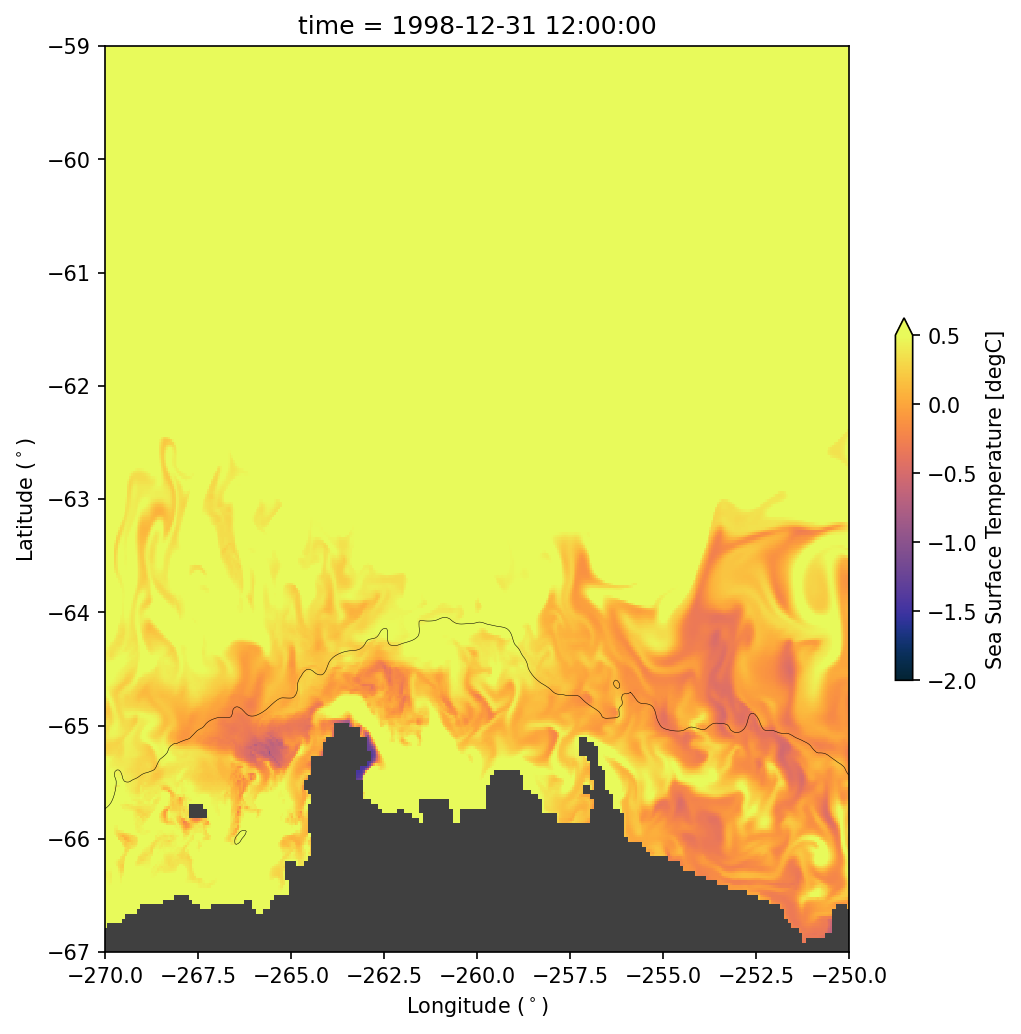

In [16]:
fontsize=12
clev2 = np.arange(0,6000,500)

fig = plt.figure(figsize=(8, 8), dpi=150)
plt.subplot(1, 1, 1)
plt.gca().patch.set_color('.25')

p2=tos.isel(time=-1).sel(yh=slice(-70,-55)).sel(xh=slice(-270,-250)).plot(vmin=-2,vmax=0.5,cmap=cm.cm.thermal,cbar_kwargs={'shrink': 0.4})
plt.contour(depth.xh,depth.yh,depth,levels=[1000],colors='k',linewidths=0.25)

plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-59])
plt.xlim([-270,-250])

# colorbar:
#ax = plt.gca()
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.2)
#cbar = plt.colorbar(p2, cax=cax,orientation = 'vertical',extend = 'neither')
#cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
#cbar.ax.tick_params(labelsize=fontsize)

#plt.savefig('figures/tos_snapshot.png')

0
10
20
30
40
50
60
70


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


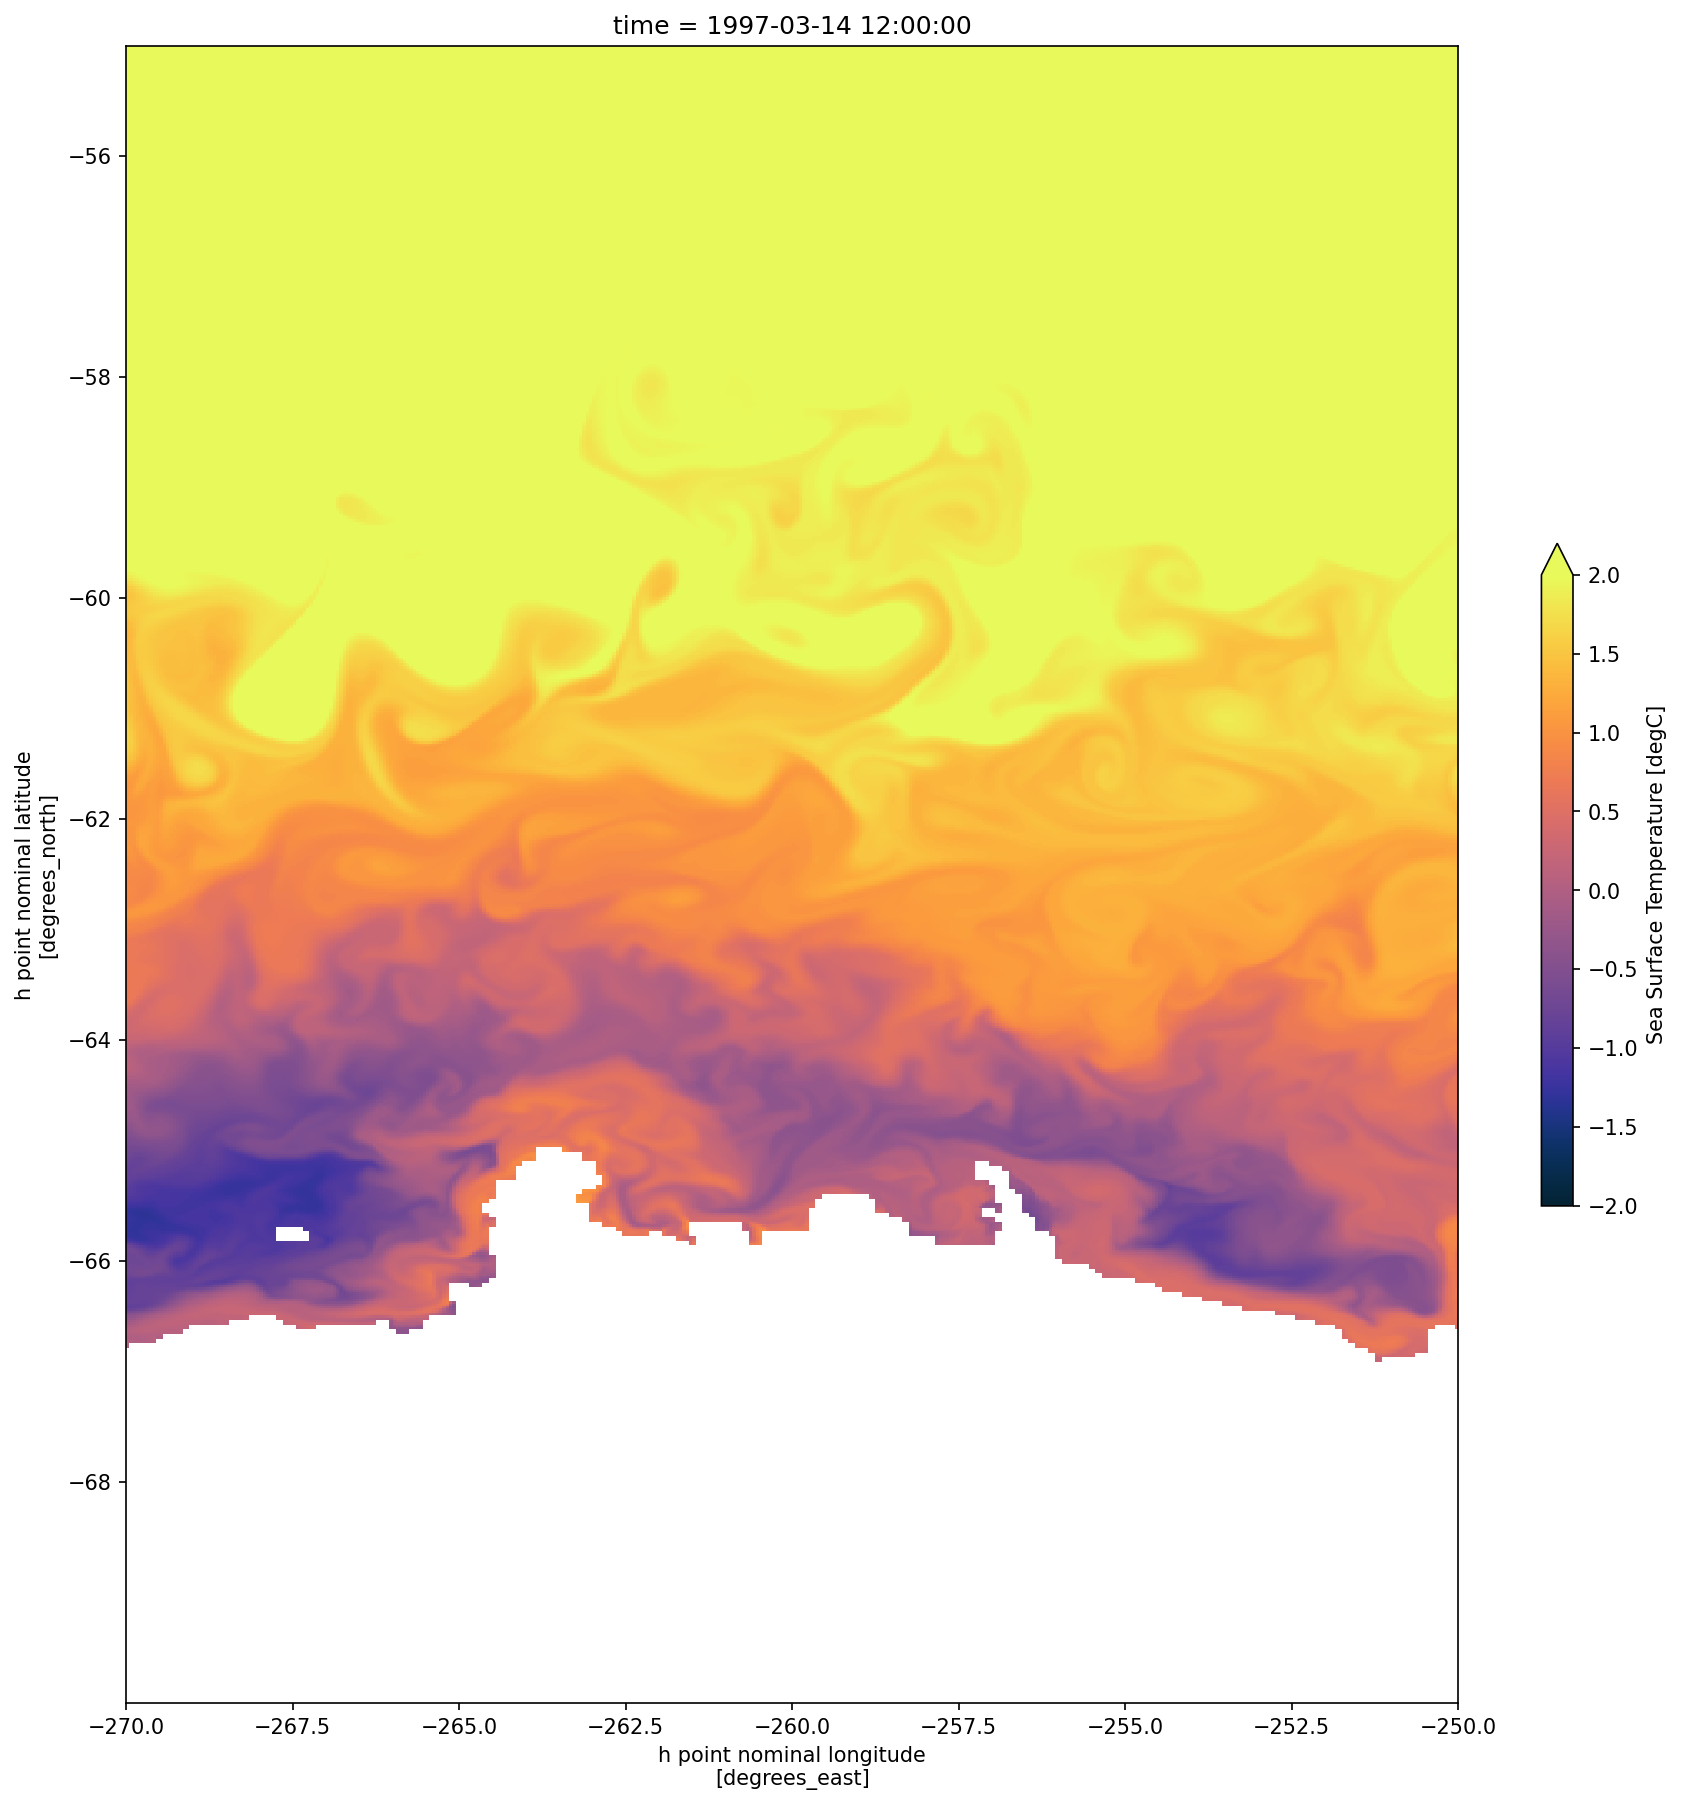

In [21]:
fig = plt.figure(figsize=(12, 12), dpi=150)
plt.subplot(1, 1, 1)
plt.gca().patch.set_color('.25')

for ii in range(tos.time.size):
    
    
    p2=tos.isel(time=ii).sel(yh=slice(-70,-55)).sel(xh=slice(-270,-250)).plot(vmin=-2,vmax=2,cmap=cm.cm.thermal,cbar_kwargs={'shrink': 0.4})
    plt.contour(depth.xh,depth.yh,depth,levels=[1000],colors='k',linewidths=0.25)

    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.ylim([-67,-59])
    plt.xlim([-270,-250])

    
    plt.tight_layout()
    
    filestr = '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage%04d.png' % ii
    plt.savefig(filestr,dpi=150)
    plt.clf()
    if np.mod(ii,10)==0:
        print(ii)

In [52]:
!ffmpeg -framerate 20 -pattern_type glob -i '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage*.png' -s 1800x1800 -c:v libx264 -pix_fmt yuv420p /home/561/pas561/gdv45/jnb/Denman/movies/PanAntSST.mp4

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavfor

In [22]:
# Create the frames
frames = []
imgs = sorted(glob.glob('/home/561/pas561/gdv45/jnb/Denman/movies/PAimage00[0-5]*.png'))

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('/home/561/pas561/gdv45/jnb/Denman/movies/PanAnt_sst_59days.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=60, loop=0)

In [20]:
imgs

['/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0000.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0001.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0002.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0003.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0004.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0005.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0006.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0007.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0008.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0009.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0010.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0011.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0012.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0013.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0014.png',
 '/home/561/pas561/gdv45/jnb/Denman/movies/PAimage0015.png',
 '/home/561/pas561/gdv45